## Exploratory Data Analysis del Caso base (para regiones)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.integrate import solve_ivp, quad
import numpy as np
from scipy.misc import derivative as dt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [2]:
fecha_inicio = pd.to_datetime("27-february-2020")
red_traf = 0.7
inicio_red = 25
f = 0.1
# params epidemiológicos
l = 1/3.3
θ = 1/(6.8 - 3.3)
pa, pm, ps = 0.5, 0.476, 0.024
σ = 1/2.4
δ = 1/5.28
ω = 1/4.27
ρ = 1/5
q = 0.0658

## Defunciones

In [3]:
defun = pd.read_csv("https://raw.githubusercontent.com/edtrelo/COVID19Model/main/data/cleandata/datosepi/defunciones_reg.csv",
           index_col = 0);
acumdefun = defun.cumsum(axis = 1).iloc[:, :75]

In [4]:
pob = pd.read_csv("https://raw.githubusercontent.com/edtrelo/COVID19Model/main/data/cleandata/pob_reg.csv", index_col = 0)

In [5]:
pob = pob['pop'].to_list()

Parece que se le puede ajustar una curva logísitca de la forma $f(x) = A + \frac{(K-A)}{C+Qe^{-Bt + J}}$. Habiendo inspeccionado todas las series del tiempo, hay algunas que no se ajustan bien (tienen muy pocos casos y hay un brinco tipo función escalera), suponemos que en estas ciudades no se registraron casos.

In [6]:
D = lambda t, K, C, Q, B, J, A: A + (K-A)/(C+Q*np.exp(-B*t + J))

In [7]:
paramsD = []

for i in range(47):

    try:
        y = acumdefun.iloc[i, :75]
        fit = optimize.curve_fit(D, list(range(20, 95)), y, maxfev=1000)[0]
        paramsD.append(fit)
    except: # los que no se ajustan bien tienen ínidces 17, 28
        paramsD.append([0, 1, 0, 0, 0])

C:\Users\Edgar Trejo\AppData\Local\Temp\ipykernel_28788\2725270811.py:1: RuntimeWarning: overflow encountered in exp
  D = lambda t, K, C, Q, B, J, A: A + (K-A)/(C+Q*np.exp(-B*t + J))


In [8]:
colores = ['dodgerblue', 'green', 'peru', 'c', 'firebrick']

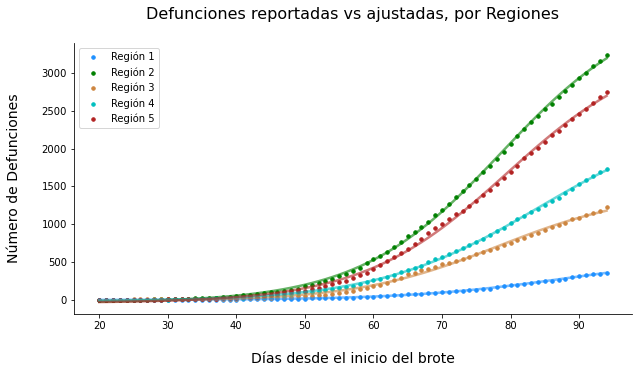

In [9]:
fig, ax = plt.subplots(figsize = (10, 5))
t = np.array(range(20, 95))
for i in range(5):
    ax.plot(t, D(t, *paramsD[i]), color = colores[i], alpha = 0.6, linewidth = 2.5)
    ax.scatter(t, acumdefun.iloc[i], 
            label = 'Región {}'.format(i+1), s = 12, c=colores[i])
    

ax.set_title('Defunciones reportadas vs ajustadas, por Regiones\n', fontsize = 16)
ax.spines['top'].set_visible(False)    
ax.spines['right'].set_visible(False)   
ax.set_ylabel('Número de Defunciones\n', fontsize = 14)
ax.set_xlabel('\nDías desde el inicio del brote\n', fontsize = 14)
ax.legend()

plt.show()

Veamos cómo se ajusta nuestro modelo de defunciones:

De la ecuación diferencial tenemos que $\frac{dD_i}{dt} = q\delta H_i(t) \Rightarrow H_i(t) = \frac{1}{q\delta}\cdot \frac{dD_i}{dt} $

In [10]:
H = lambda t, i: 1/(q*δ) * dt(D, t, n=1, args = (*paramsD[i], ))

Además, $\frac{dH_i}{dt} = \omega I_{ss_i} - q\delta H_i - (1-q)\rho H_i \Rightarrow I_{ss_i}(t) = \frac{1}{\omega}\left(\frac{dH_i}{dt} + \left(q\delta + (1-q)\rho\right)H_i \right)$

In [11]:
Iss = lambda t, i : (dt(H, t, n=1, args = (i,)) + (q*δ + (1-q)*ρ)*H(t, i))/ω

Luego, $\frac{dI_{ss_i}}{dt} = \theta p_s I_{p_i} - \omega I_{ss_i}$, de donde $I_{p_i}(t) = \frac{1}{\theta p_s}\left(\frac{dI_{ss_i}}{dt} + \omega I_{ss_i} \right)$

In [12]:
Ip = lambda t, i: 1/(θ*ps)*(dt(Iss, t, n=1, args = (i, )) + ω*Iss(t, i))

In [13]:
Ip0 = [int(Ip(0, i)) for i in range(5)]

In [14]:
Ip0

[108, 981, 338, 732, 823]

Luego $\frac{dI_{p_i}}{dt} = \ell E_i(t) - \theta I_{p_i}$

$E_i(t) = \frac{1}{\ell}\left(\frac{dI_{p_i}}{dt}+\theta I_{p_i}\right)$

In [15]:
E = lambda t, i: 1/(l)*(dt(Ip, t, n=1, args = (i, )) + θ*Ip(t, i))

In [16]:
E0 = [int(E(0, i)) for i in range(5)]

In [17]:
E0

[133, 1236, 428, 897, 1035]

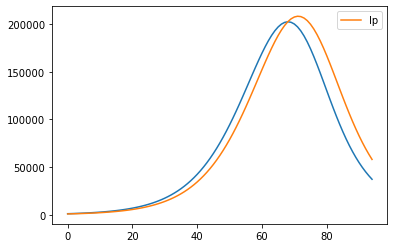

In [18]:
t = np.array(range(95))
plt.plot(t, E(t, 4))
plt.plot(t, Ip(t, 4), label = 'Ip')

plt.legend()
plt.show()

$\frac{dE_i}{dt}= -\frac{dS_i}{dt} - \epsilon E_i$

$S_i(\tau) = -\ell\displaystyle\int_0^\tau E_i(t)\ dt - E_i(\tau) + S_i(0) + E_i(0)$

In [19]:
S = lambda t, i: -l*quad(E, 0, t, args = (i, ))[0] - E(t,i) + (pob[i] - Ip0[i])

In [20]:
T = np.array(range(95))

In [21]:
Sarray = np.zeros((5, 95))

In [22]:
for i in range(5):
    Sarray[i] = [S(t, i) for t in T]

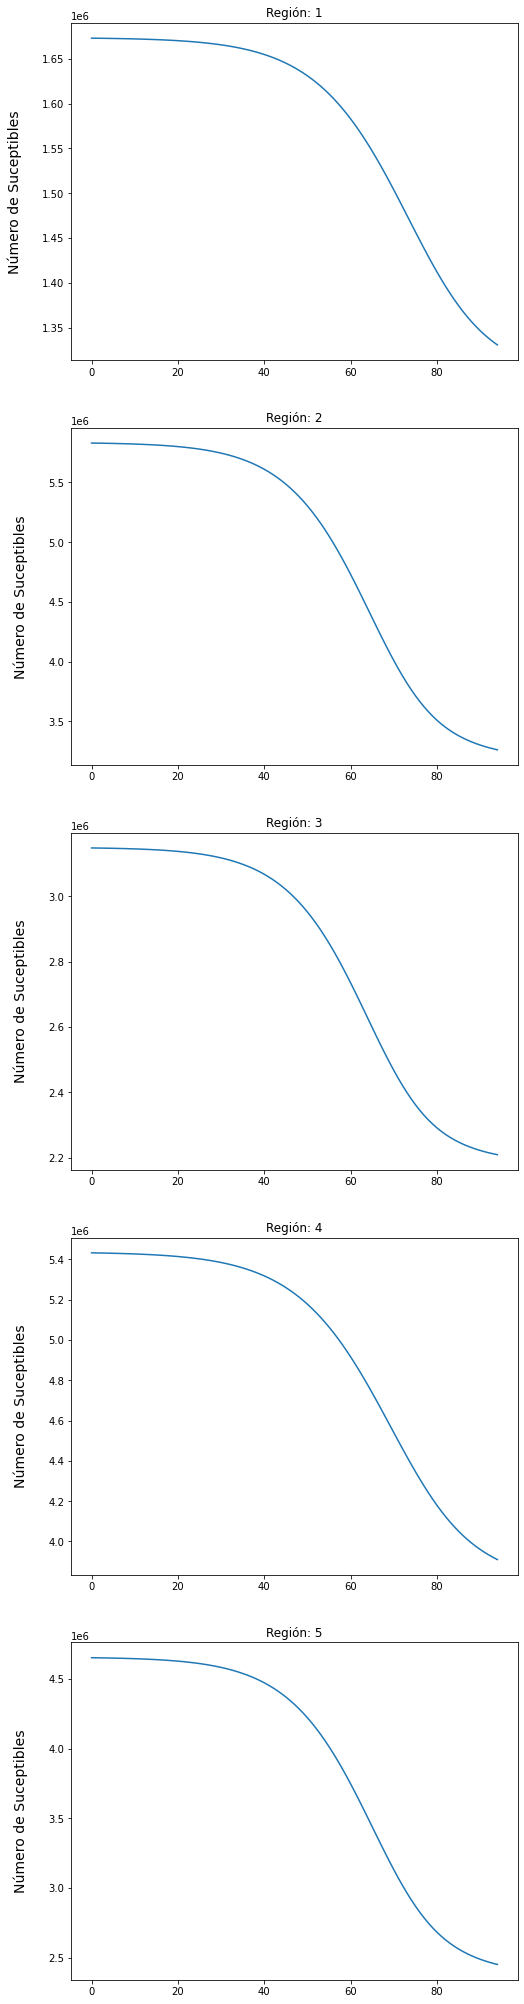

In [23]:
fig, ax = plt.subplots(5, figsize = (8, 36))

t = np.array(range(95))

for i in range(5):
    ax[i].plot(t, Sarray[i])
    ax[i].set_title('Región: {}'.format(i+1))
    ax[i].set_ylabel('Número de Suceptibles\n', fontsize = 14)

Para el resto de los infectados, podemos resolver sus ecuaciones diferenciales de manera numérica:

In [24]:
def IaEDO(t, X):
    """Modelo metapoblacional de la dinámica del covid-19 por Calvetti, et. al. Establece el sistema de edo para los parámetros
    mu en R y Br en R^n."""
        
    dXdt = np.zeros(5)
    
    Ia = lambda i: X[i]
            
    for i in range(5):
        # X_i; los componentes de cada ciudad
                
        # ecuación de los suceptibles para la ciudad i
        dXdt[i] = θ*pa*Ip(t, i) - σ*Ia(i)
            
    return dXdt

tdata = np.linspace(0, 94, 95)
Ia0 = np.zeros(5)
indicesCasos = [0, 4]
Ia0[indicesCasos] = 1


solIa = solve_ivp(IaEDO, (0, 94), Ia0, t_eval = tdata)

In [25]:
Ia = lambda t, i: solIa.y[i, np.array(t).astype(int)]

In [26]:
Ia0 = [int(Ia(0, i)) for i in range(5)]

In [27]:
Ia0

[1, 0, 0, 0, 1]

In [28]:
def ImEDO(t, X):
    """Modelo metapoblacional de la dinámica del covid-19 por Calvetti, et. al. Establece el sistema de edo para los parámetros
    mu en R y Br en R^n."""
        
    dXdt = np.zeros(5)
    
    Im = lambda i: X[i]
            
    for i in range(5):
        # X_i; los componentes de cada ciudad
                
        # ecuación de los suceptibles para la ciudad i
        dXdt[i] = θ*pm*Ip(t, i) - σ*Im(i)
            
    return dXdt

tdata = np.linspace(0, 94, 95)
Im0 = np.zeros(5)

solIm = solve_ivp(ImEDO, (0, 94), Im0, t_eval = tdata)

In [31]:
Im = lambda t, i: solIm.y[i, np.array(t).astype(int)]

In [32]:
Im0 = [int(Im(0, i)) for i in range(5)]

In [33]:
Im0

[0, 0, 0, 0, 0]

$\ell E_i + \frac{dE_i}{dt} = \lambda_i(t)S_i \Rightarrow \lambda_i(t) = \frac{\ell E_i}{S_i} + \frac{\frac{dE_i}{dt}}{S_i}$

In [36]:
λ = lambda t, i: (dt(E, t, n = 1, args = (i, )) + l*E(t,i) )/ Sarray[i, np.array(t).astype(int)]

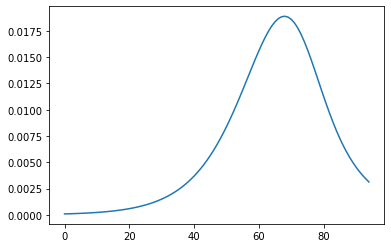

In [38]:
t = np.array(range(95))

plt.plot(λ(t, 4))

In [39]:
es = pd.read_csv("https://raw.githubusercontent.com/edtrelo/COVID19Model/main/data/cleandata/viajes/viajes_es_reg.csv",
                index_col = 0)

s = pd.read_csv("https://raw.githubusercontent.com/edtrelo/COVID19Model/main/data/cleandata/viajes/viajes_s_reg.csv",
                index_col = 0)

d = pd.read_csv("https://raw.githubusercontent.com/edtrelo/COVID19Model/main/data/cleandata/viajes/viajes_d_reg.csv",
                index_col = 0)

In [40]:
dfx0 = {'Ip0':Ip0, 'E0': E0}

In [41]:
df = pd.DataFrame(dfx0)

In [42]:
df.index = es.index

In [43]:
df.to_csv("D:/Edgar Trejo/Universidad/Proyecto/COVID19Model/data/cleandata/x0_reg.csv")

In [44]:
inicio_red = 25

Intento para ajustar la fuerza de infección del modelo de calveti:

In [45]:
v = [es, s, d]

In [46]:
v

[              0        1        2        3        4
 region                                             
 0       2382289  1079334  1141035  1359242   384878
 1       1076048  6282064  1334889  1777230  1182559
 2       1141251  1349372  3623554  1308268   440746
 3       1358850  1782918  1305329  4939680   535819
 4        384729  1189114   439093   537649  3503739,
               0        1        2        3        4
 region                                             
 0       1043921    65084    24031   141199    89947
 1         66263  4859614   345421   615476   836719
 2         25936   349584  2217640    99539   164251
 3        142685   628699    95929  3011256   194378
 4         89726   850754   161951   197189  2976564,
              0        1        2        3        4
 region                                            
 0       694264    88735    68459   145211    69833
 1        89460  3026357   260749   430899   526743
 2        69627   263306  1414487   119649   115

In [47]:
N = lambda t, i: pob[i]-D(t, *paramsD[i])

In [48]:
γ = lambda t, i: N(t,i)/pob[i]

In [480]:
(fecha_inicio.weekday() + 0.666) % 7

3.666

In [481]:
def Ω(i, j, d):
    wd = int((fecha_inicio.weekday() + d) % 7)
    
    if wd == 5:
        p = v[1].iloc[i, j] / sum(v[1].iloc[i])
        
    elif wd == 6:
        p = v[2].iloc[i, j] / sum(v[2].iloc[i])
                 
    else:
        p = v[0].iloc[i, j] / sum(v[0].iloc[i])
        
    if d > inicio_red:
        p = (1-red_traf)*p
                
    return p

In [482]:
Ω = np.vectorize(Ω)

In [483]:
f

0.1

In [52]:
def L(t, i):
    return sum((β(t, k)* Ω(i, k, t) * sum(( Ω(m, k, t) * (Ip(t, m) + Ia(t, m) + f*Im(t, m))  for m in range(5) ))  for k in range(5)))

In [53]:
L = np.vectorize(L)

In [54]:
red_traf

0.7

In [484]:
sols = []

In [485]:
x = np.linspace(0, 94, 5000)

In [486]:
for t in x:
    A = np.zeros((5, 5))
    b = np.zeros(5)
    for i in range(5):
        for j in range(5):
            A[i, j] = Ω(i, j, t)* sum([Ω(m, j, t) * (Ip(t, m) + Ia(t, m) + f*Im(t, m))  for m in range(5)])
        b[i] = λ(t, i)
    X = np.linalg.solve(A, b)
    sols.append(X)

In [487]:
Sols = np.array(sols)

In [488]:
len(Sols)

5000

In [489]:
Sols

array([[-1.63923877e-07,  1.26663824e-07,  1.18287266e-07,
         1.16688849e-07,  1.58730905e-07],
       [-1.63956703e-07,  1.26675051e-07,  1.18324414e-07,
         1.16657567e-07,  1.58733243e-07],
       [-1.63989529e-07,  1.26686276e-07,  1.18361559e-07,
         1.16626283e-07,  1.58735580e-07],
       ...,
       [ 9.60199203e-07,  2.50983915e-07,  2.32754752e-07,
         3.52165356e-07,  4.77667268e-07],
       [ 9.59527656e-07,  2.50791363e-07,  2.32573780e-07,
         3.51959692e-07,  4.77327672e-07],
       [ 9.94401300e-07,  2.61197627e-07,  1.70181505e-07,
         3.73901406e-07,  5.04884877e-07]])

### Ajuste de la serie de tiempo a un polinomio

In [433]:
o = 5000-3670

In [434]:
x[o]

25.009001800360075

In [553]:
limits = [0]

In [554]:
for i in range(25, 95, 7):
    limits.append(i)

In [555]:
limits.append(95)

In [556]:
limits

[0, 25, 32, 39, 46, 53, 60, 67, 74, 81, 88, 95]

In [626]:
paramsP = []
for i in range(len(limits)-1):
    paramsB = []
    for j in range(5):
        z = x[np.logical_and(x>=limits[i], x<=limits[i+1])]
        y = Sols[np.logical_and(x>=limits[i], x<=limits[i+1]), j]
        fit = np.polyfit(z, y, 10)
        paramsB.append(fit)
        
    paramsP.append(paramsB)

C:\Users\Edgar Trejo\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3398: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Edgar Trejo\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3398: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Edgar Trejo\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3398: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Edgar Trejo\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3398: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Edgar Trejo\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3398: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Edgar Trejo\anaconda3\lib\site-packages\IPython\core\int

In [627]:
def β(x, i):
    for j in range(len(paramsP)):
        if x>= limits[j] and x<=limits[j+1]:
            return np.polyval(paramsP[j][i], x)
    
β = np.vectorize(β)

In [628]:
β(0, 0)

array(-1.93701238e-08)

In [630]:
x

array([0.00000000e+00, 1.88037608e-02, 3.76075215e-02, ...,
       9.39623925e+01, 9.39811962e+01, 9.40000000e+01])

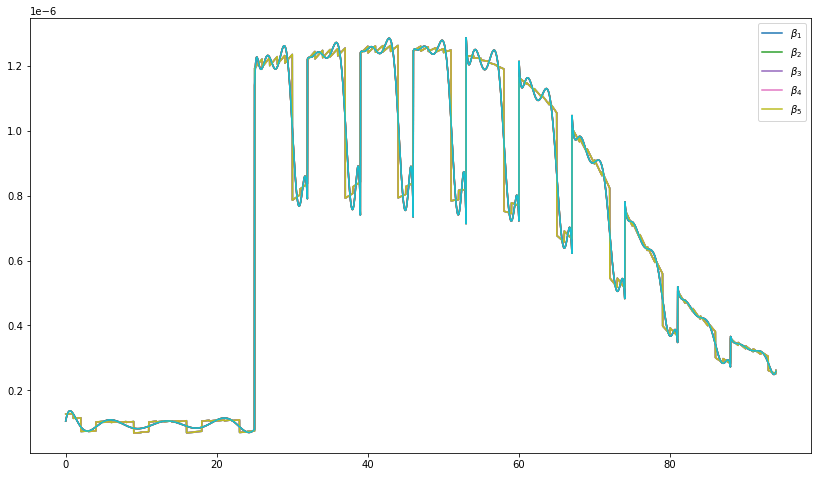

In [638]:
fig, ax = plt.subplots(figsize = (14, 8))

for i in range(5):
    ax.plot(x, Sols[:, 1], label = r'$\beta_{}$'.format(i+1))
    ax.plot(x, β(x, 1))    
    
ax.legend()
plt.show()

In [639]:
t = np.array(range(95))

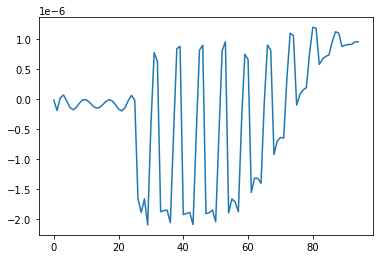

In [640]:
plt.plot(β(t, 0))

In [641]:
def L(t, i):
    return sum((β(t, k)* Ω(i, k, t) * sum(( Ω(m, k, t) * (Ip(t, m) + Ia(t, m) + f*Im(t, m))  for m in range(5))) for k in range(5)))

In [644]:
λ(60, 0)

0.00402556312785694

In [645]:
L(60, 0)

0.007358633364845379

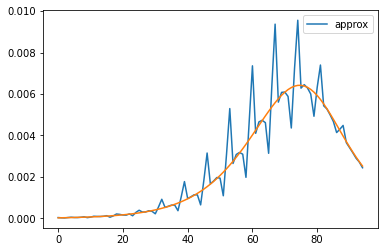

In [637]:
t = np.array(range(95))

plt.plot(L(t, 0), label ='approx')
plt.plot(λ(t, 0))

plt.legend()

In [426]:
Sols

array([[-1.63923877e-07,  1.26663824e-07,  1.18287266e-07,
         1.16688849e-07,  1.58730905e-07],
       [-1.63956703e-07,  1.26675051e-07,  1.18324414e-07,
         1.16657567e-07,  1.58733243e-07],
       [-1.63989529e-07,  1.26686276e-07,  1.18361559e-07,
         1.16626283e-07,  1.58735580e-07],
       ...,
       [ 9.16799674e-07,  2.98457859e-07, -2.63180040e-07,
         4.67115251e-07,  6.01136318e-07],
       [ 9.16426997e-07,  2.98184989e-07, -2.63172665e-07,
         4.66892723e-07,  6.00695687e-07],
       [ 9.94401300e-07,  2.61197627e-07,  1.70181505e-07,
         3.73901406e-07,  5.04884877e-07]])

In [357]:
L(80, 0)

0.004492940002383086

In [630]:
red_traf = 0.7

In [631]:
pd.DataFrame(Sols).to_csv('D:/Edgar Trejo/Universidad/Proyecto/COVID19Model/data/cleandata/params.csv', index=False)

In [632]:
Sols.shape

(95, 5)

In [359]:
inicio_red

25

In [646]:
def Model(t, X, params):
    
    dXdt = np.zeros(5*8)
    
    S = lambda i: X[8*i + 0]
    E = lambda i: X[8*i + 1]
    Ip = lambda i: X[8*i + 2]
    Iss =  lambda i: X[8*i + 3]
    H = lambda i: X[8*i + 4]
    D = lambda i: X[8*i + 5]
    Ia = lambda i: X[8*i + 6]
    Im = lambda i: X[8*i + 7]
    
    red_traf = params
    
    def Ω(i, j, dia):
        
        wd = int((fecha_inicio.weekday() + dia) % 7)
        if wd == 5:
            p = v[1].iloc[i, j] / sum(v[1].iloc[i])
        elif wd == 6:
            p = v[2].iloc[i, j] / sum(v[2].iloc[i])   
        else:
            p = v[0].iloc[i, j] / sum(v[0].iloc[i])
    
        if dia > inicio_red:
            p = (1-red_traf)*p 
        
        return p
    
    L = lambda t, i: sum((β(t,k)*Ω(i, k, t)* sum([Ω(m, k, t) * (Ip(m) + Ia(m) + f*Im(m)) for m in range(5)]) for k in range(5)))
    
    for i in range(5):    
        # X_i; los componentes de cada ciudad
        # ecuación de los suceptibles para la ciudad i
        fuerza = L(t, i)
        dXdt[8*i + 0] = -fuerza*S(i)
        # ecuación de los expuestos para la ciudad i
        dXdt[8*i + 1] = fuerza*S(i) - l*E(i)
        # ecuación para los pre-infectados
        dXdt[8*i + 2] = l*E(i) - θ*Ip(i)
        # ecuación para los infectados severos
        dXdt[8*i + 3] = θ*ps*Ip(i) - ω*Iss(i)
        # ecuación para los hospitalizados
        dXdt[8*i + 4] = ω*Iss(i) - (1-q)*ρ*H(i) - δ*q*H(i)
        # ecuación de los difuntos
        dXdt[8*i + 5] = q*δ*H(i)
        # ecuación de los asintomáticos
        dXdt[8*i + 6] = θ*pa*Ip(i) - σ*Ia(i)
        # ecuación de los mild sym
        dXdt[8*i + 7] = θ*pm*Ip(i) - σ*Im(i)

    return dXdt

In [473]:
x0df = pd.read_csv("https://raw.githubusercontent.com/edtrelo/COVID19Model/main/data/cleandata/x0_reg.csv", index_col = 0)

In [474]:
x0 = []
indicesCasos = [0, 4]

for i in range(5):
    if i in indicesCasos:
        x0.extend([pob[i]-x0df.iloc[i, 0]-x0df.iloc[i, 1]-1, x0df.iloc[i, 1], x0df.iloc[i, 0], 0, 0, 0, 1, 0])
    else:
        x0.extend([pob[i]-x0df.iloc[i, 0]-x0df.iloc[i, 1], x0df.iloc[i, 1], x0df.iloc[i, 0], 0, 0, 0, 0, 0])

In [647]:
def solucionar(r = 0.7):
        """Función que ocupamos para obtener la solución del sistema y que va 
        a ajustarse a los datos."""

        t = np.array(range(94))
    
        solu = solve_ivp(Model, (0, 94), x0, t_eval = t, method = 'LSODA', args=(r,) )
        
    
        return solu.y

Solución del caso base:

In [648]:
s = solucionar()

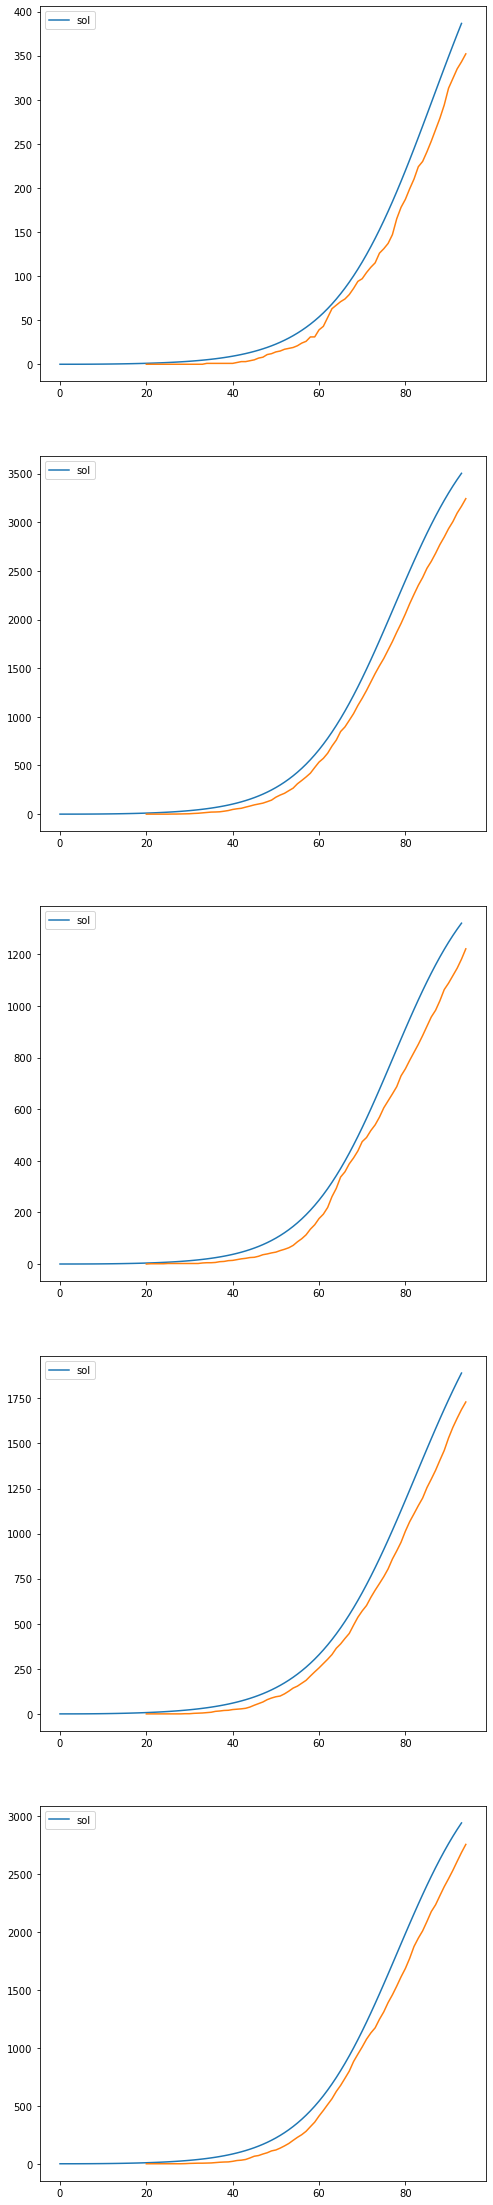

In [649]:
fig, ax = plt.subplots(5, figsize = (8, 40))

for i in range(5):
    ax[i].plot(range(0, 94), s[8*i + 5], label = 'sol')
    ax[i].plot(range(20, 95), acumdefun.iloc[i])
    ax[i].legend()

In [511]:
camas = np.array(pob)/1000

In [512]:
camas

array([1673.172, 5831.096, 3148.49 , 5433.705, 4654.189])

C:\Users\Edgar Trejo\AppData\Local\Temp\ipykernel_28788\3093627347.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1,0].set_yticklabels(['-20', '0', '20', '40', '60', '80', '100', '120', '140'])


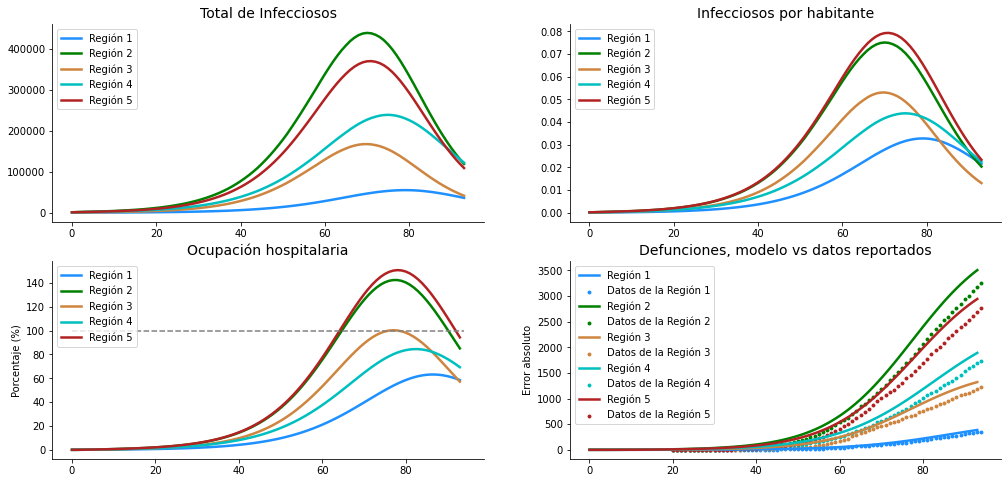

In [669]:
t  = np.array(range(94))

fig, ax = plt.subplots(2, 2, figsize = (17, 8))

for i in range(5):
    ax[0, 0].plot(s[8*i + 6] + s[8*i + 7] + s[8*i + 2], label = 'Región {}'.format(i+1), color = colores[i], linewidth = 2.5)
    ax[0, 1].plot((s[8*i + 6] + s[8*i + 7] + s[8*i + 2])/pob[i],  label = 'Región {}'.format(i+1), color = colores[i], linewidth = 2.5)
    ax[1, 0].plot(s[8*i + 4]/ camas[i], color = colores[i], label = 'Región {}'.format(i+1), linewidth = 2.5)
    ax[1, 1].plot((s[8*i + 5]), color = colores[i], linewidth = 2.5, 
                 label = 'Región {}'.format(i+1))
    ax[1, 1].scatter(range(20, 95), acumdefun.iloc[i], color = colores[i], linewidth = 2.5, 
                 label = 'Datos de la Región {}'.format(i+1), s = 2)

    

ax[0,0].set_title('Total de Infecciosos', fontsize = 14)   
ax[0,1].set_title('Infecciosos por habitante', fontsize = 14)  
ax[1,0].set_title('Ocupación hospitalaria', fontsize = 14)
ax[1,1].set_title('Defunciones, modelo vs datos reportados', fontsize = 14)  

ax[1,0].set_ylabel('Porcentaje (%)')
ax[1,1].set_ylabel('Error absoluto')

for a in ax.ravel():
    a.legend()
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    
ax[1,0].set_yticklabels(['-20', '0', '20', '40', '60', '80', '100', '120', '140'])
ax[1,0].hlines(1.0, 0, 94, linestyle = '--', color = 'grey')
    
plt.show()

In [670]:
infecciosos = np.array([s[8*i + 6] + s[8*i + 7] + s[8*i + 2] for i in range(5)])

In [671]:
np.argmax(infecciosos, axis = 1)

array([79, 70, 70, 75, 71], dtype=int64)

In [688]:
np.argmax(hosp, axis = 1)

array([87, 77, 77, 82, 78], dtype=int64)

In [687]:
hosp = np.array([casobase[8*i + 4] for i in range(5)])

In [672]:
sum(abs(np.array([s[8*i + 5, 20:]- acumdefun.iloc[i, :-1] for i in range(5)])).ravel() )/ len(abs(np.array([s[8*i + 5, 20:]- acumdefun.iloc[i, :-1] for i in range(5)])).ravel() )

95.08749416089779

In [675]:
casobase = s

In [679]:
np.savetxt("D:/Edgar Trejo/Universidad/Proyecto/COVID19Model/data/results/casobase.csv", casobase, delimiter=",")

## Diferentes magnitudes en las reducciones

In [677]:
reds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

In [678]:
solsRed = []

In [681]:
for r in reds:
    y = solucionar(r)
    solsRed.append(y)

In [141]:
for i, s in enumerate(solsRed):
    np.savetxt("D:/Edgar Trejo/Universidad/Proyecto/COVID19Model/data/results/reduccioneshomg/redhomogenea_{}.csv".format(i), s, delimiter=',')

In [142]:
red_traf = 0.7

In [144]:
indices = [0, 2, 4, 6, 8, 10]

In [ ]:
N = lambda t, i: pob[i] - 

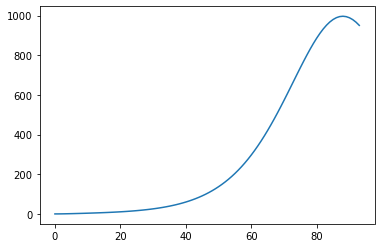

In [174]:
plt.plot(solsRed[0][4])

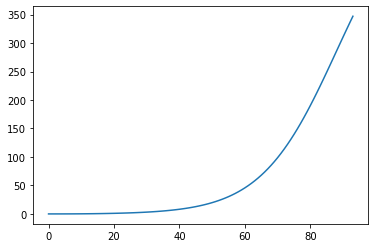

In [154]:
plt.plot(solsRed[0][5])

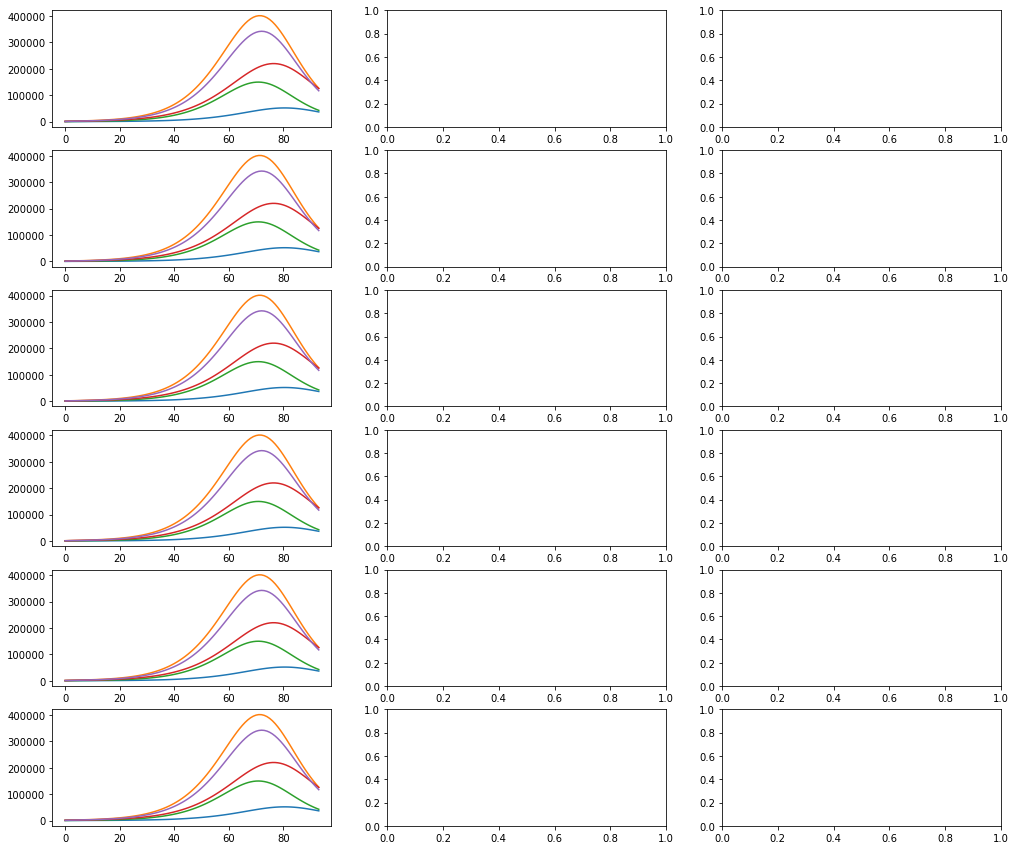

In [150]:
t  = np.array(range(94))

fig, ax = plt.subplots(6, 3, figsize = (17, 15))

for i in range(6):
    for j in range(5):
        ax[i, 0].plot((solsRed[indices[i]][8*j + 6] + solsRed[indices[i]][8*j + 7] + solsRed[indices[i]][8*j + 2]), label = 'Región {}'.format(j+1))

C:\Users\Edgar Trejo\AppData\Local\Temp\ipykernel_20824\3137318856.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1,0].set_yticklabels(['-20', '0', '20', '40', '60', '80', '100', '120', '140'])


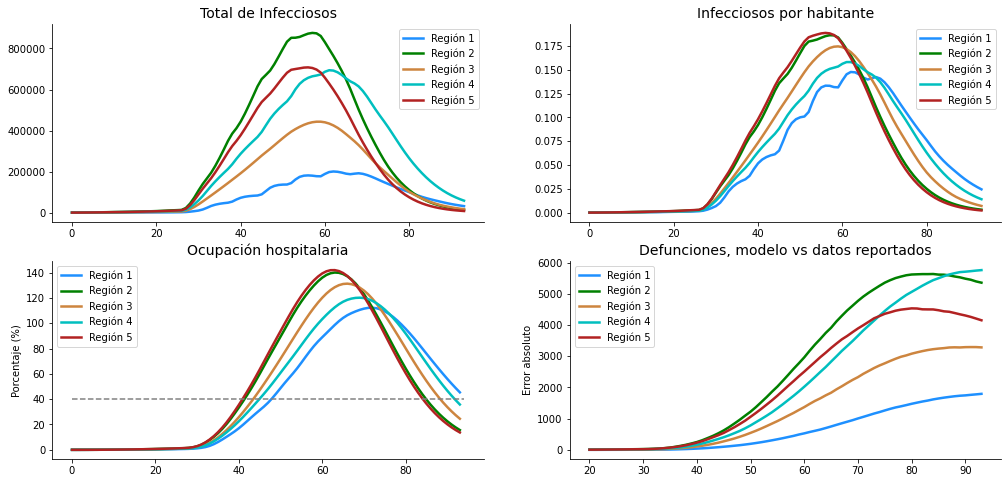

In [563]:
t  = np.array(range(94))

fig, ax = plt.subplots(2, 2, figsize = (17, 8))

for i in range(5):
    ax[0, 0].plot(solsRed[0][8*i + 6] + [8*i + 7] + solsRed[0][8*i + 2], label = 'Región {}'.format(i+1), color = colores[i], linewidth = 2.5)
    ax[0, 1].plot((solsRed[0][8*i + 6] + solsRed[0][8*i + 7] + solsRed[0][8*i + 2])/N(t,i),  label = 'Región {}'.format(i+1), color = colores[i], linewidth = 2.5)
    ax[1, 0].plot(solsRed[0][8*i + 4]/ camas[i], color = colores[i], label = 'Región {}'.format(i+1), linewidth = 2.5)
    ax[1, 1].plot(range(20, 94), (solsRed[0][8*i + 5, 20:]- acumdefun.iloc[i, :-1]), color = colores[i], linewidth = 2.5, 
                 label = 'Región {}'.format(i+1))

    

ax[0,0].set_title('Total de Infecciosos', fontsize = 14)   
ax[0,1].set_title('Infecciosos por habitante', fontsize = 14)  
ax[1,0].set_title('Ocupación hospitalaria', fontsize = 14)
ax[1,1].set_title('Defunciones, modelo vs datos reportados', fontsize = 14)  

ax[1,0].set_ylabel('Porcentaje (%)')
ax[1,1].set_ylabel('Error absoluto')

for a in ax.ravel():
    a.legend()
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    
ax[1,0].set_yticklabels(['-20', '0', '20', '40', '60', '80', '100', '120', '140'])
ax[1,0].hlines(1.0, 0, 94, linestyle = '--', color = 'grey')
    
plt.show()